In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

# **Let's Load the dataset first**

In [ ]:
import os

paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Data is ready for pre-processing.')

Data is ready for pre-processing.


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data/OAF_disgust/OAF_death_disgust.wav',
 '/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data/OAF_disgust/OAF_calm_disgust.wav',
 '/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav',
 '/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data/OAF_disgust/OAF_goose_disgust.wav',
 '/content/drive/MyDrive/SIH 2024/TESS Toronto emotional speech set data/OAF_disgust/OAF_fail_disgust.wav']

In [ ]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [ ]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/SIH 2024/TESS Toronto e...,disgust
1,/content/drive/MyDrive/SIH 2024/TESS Toronto e...,disgust
2,/content/drive/MyDrive/SIH 2024/TESS Toronto e...,disgust
3,/content/drive/MyDrive/SIH 2024/TESS Toronto e...,disgust
4,/content/drive/MyDrive/SIH 2024/TESS Toronto e...,disgust


In [ ]:
df['label'].value_counts()

label
fear       600
sad        600
angry      400
neutral    400
happy      400
disgust    200
ps         200
Name: count, dtype: int64

# **Exploratory Data Analysis**

<Axes: xlabel='label', ylabel='count'>

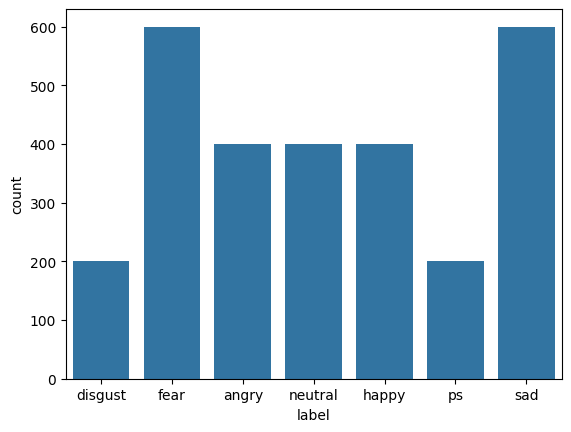

In [ ]:
sns.countplot(data=df, x='label')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

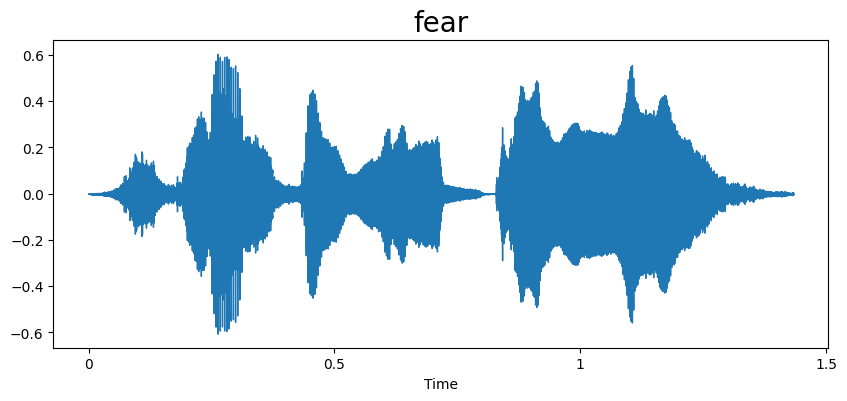

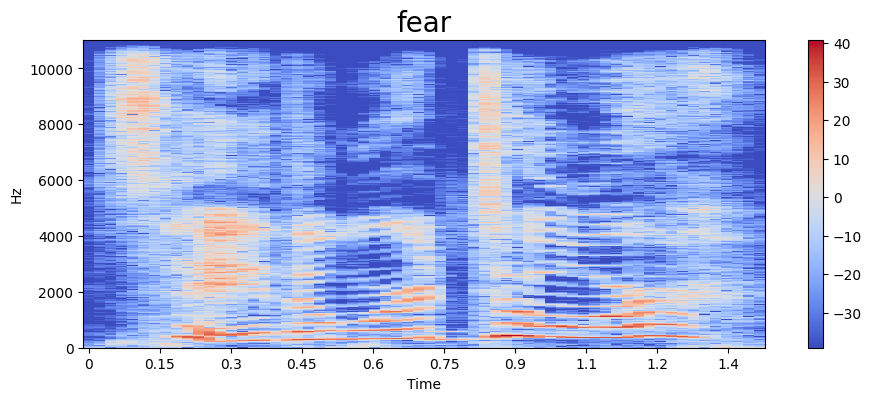

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

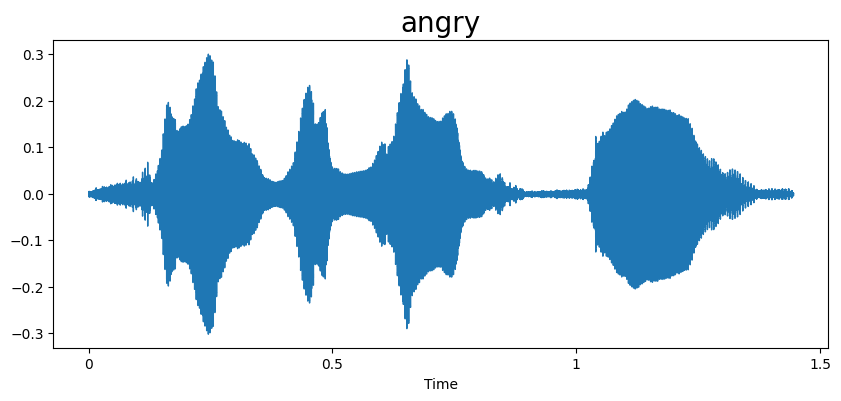

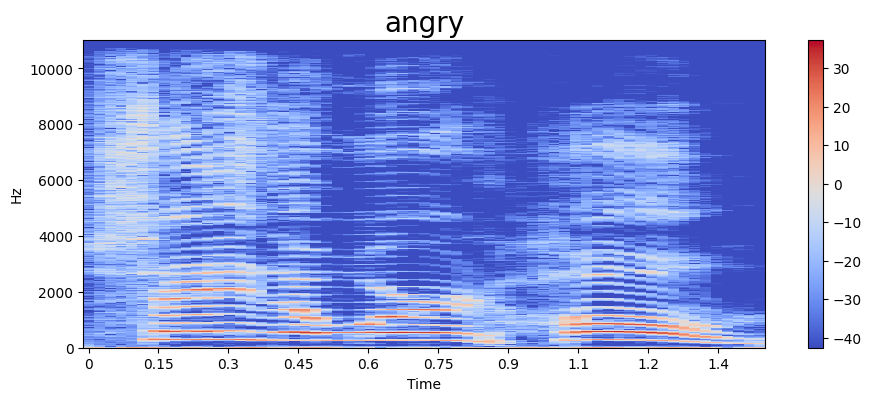

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

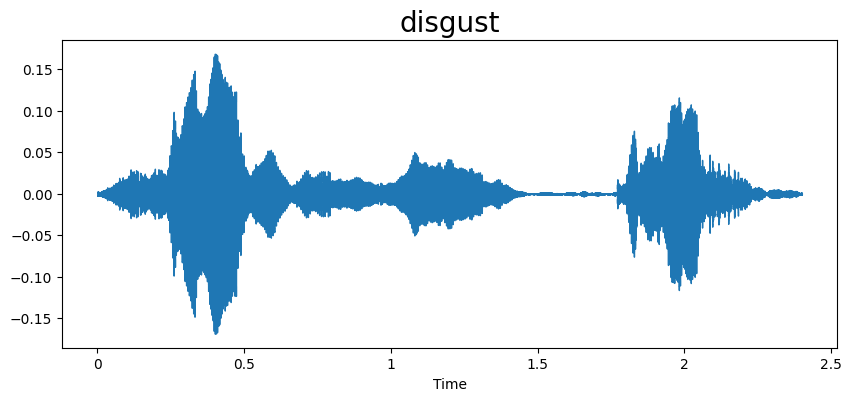

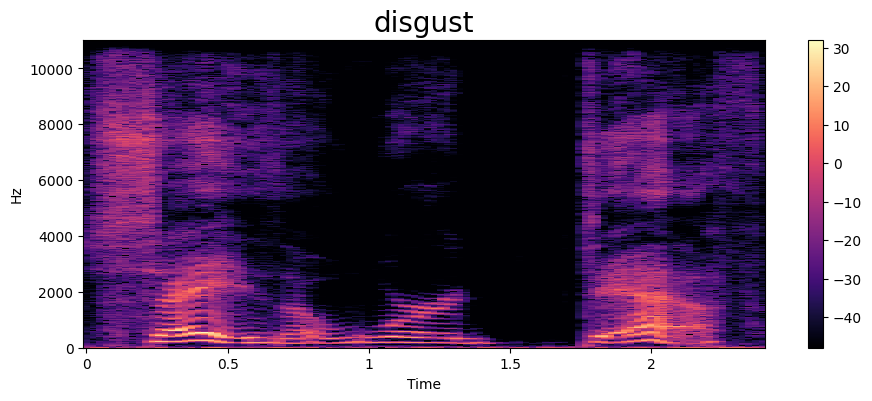

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

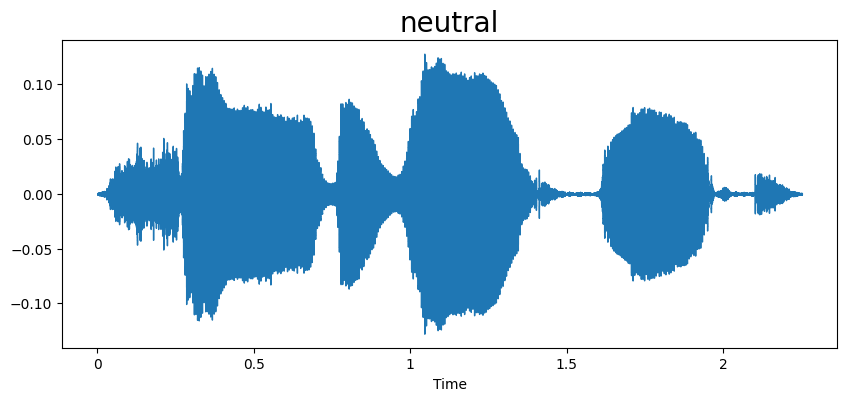

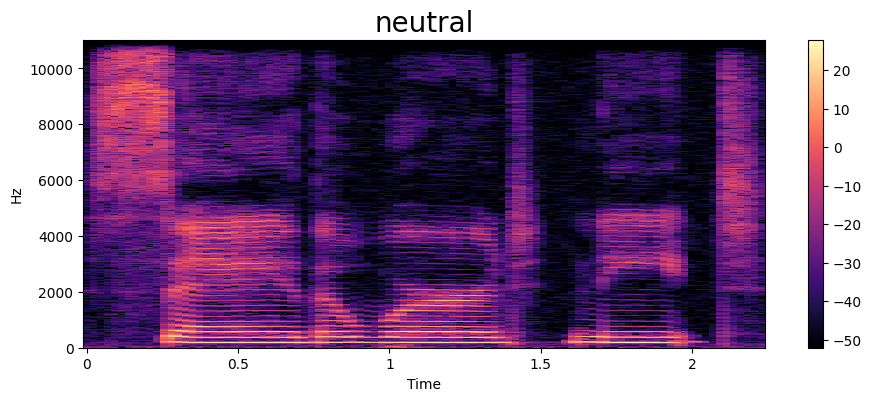

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

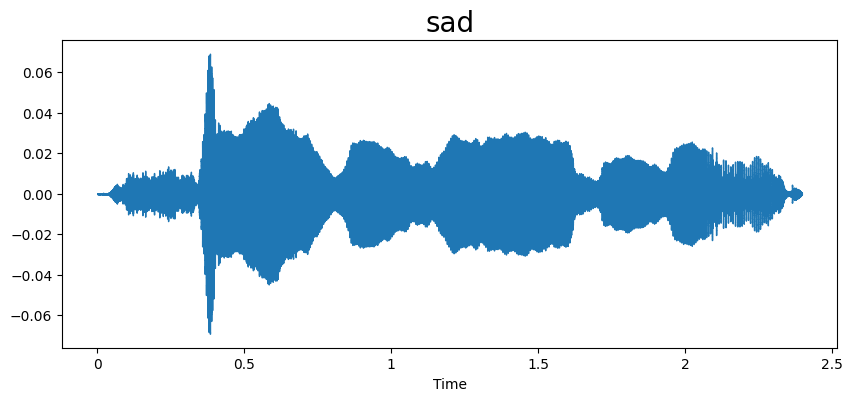

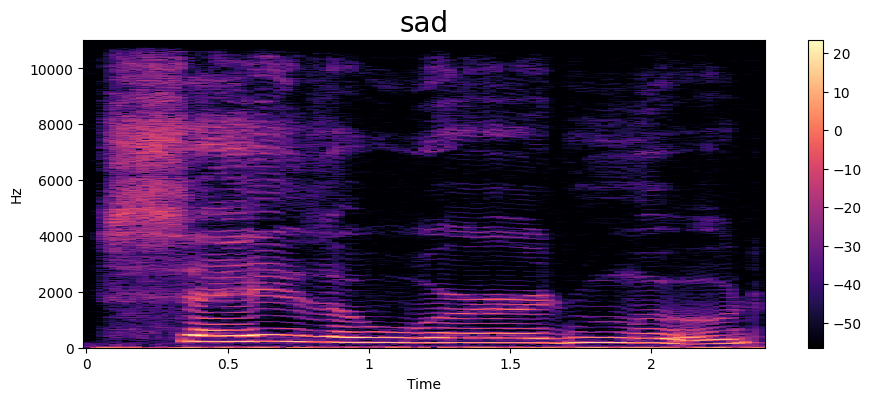

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

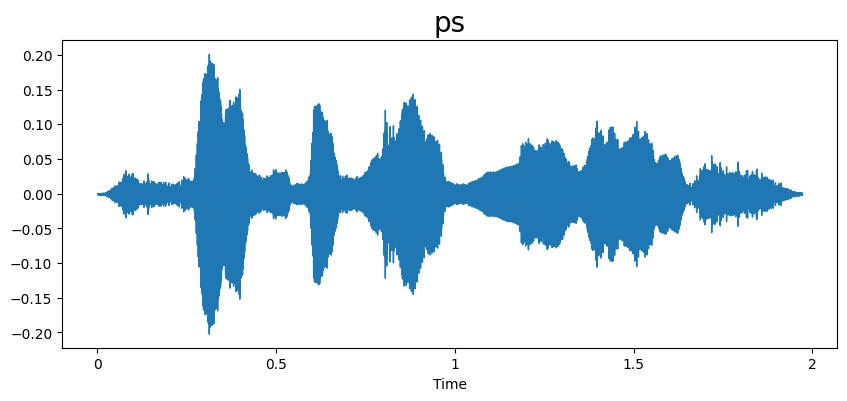

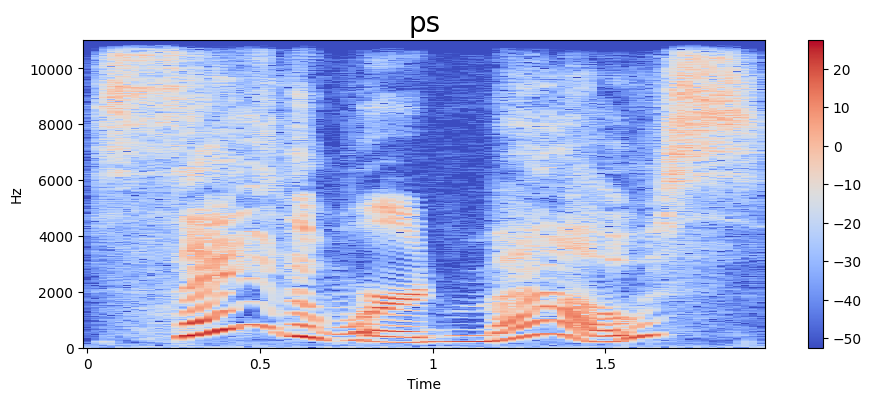

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

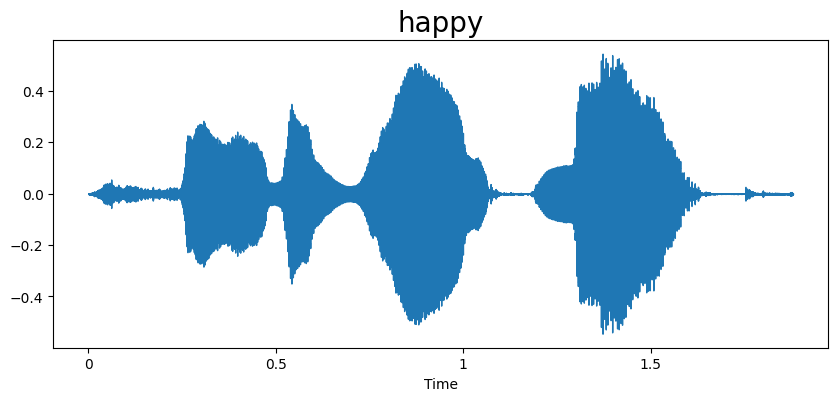

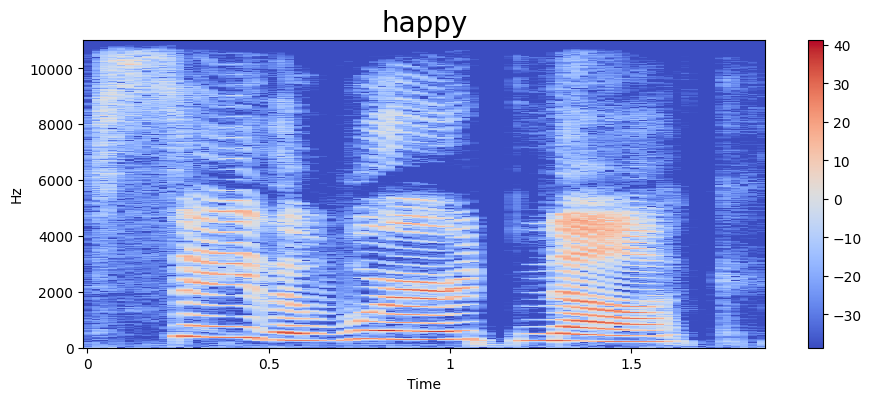

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# **Feature Extraction**

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['speech'][0])

array([-5.0951996e+02,  1.0182335e+02,  2.9332890e+01, -5.9342647e+00,
        1.9440298e+01,  9.0501709e+00, -1.0899654e+01,  6.9343367e+00,
       -1.6169226e+01,  3.5955467e+00, -3.3898168e+00, -2.4082739e+00,
       -2.0608344e+00, -1.2964347e-01, -3.5885286e+00,  1.3920207e+00,
       -3.5180321e+00,  4.5827479e+00, -1.0795981e+00, -1.2887965e+00,
        1.7323884e+00, -5.0821614e+00, -2.4733417e+00, -1.6948010e+00,
       -1.3513312e+00,  6.6541572e+00, -5.3241949e+00,  1.8288282e+00,
       -1.9971749e+00,  1.8175313e+00, -9.6653491e-02,  1.7407578e+00,
       -4.9654763e-02,  4.5713835e+00,  4.0791059e+00,  1.0508831e+01,
        7.9752631e+00,  1.1574847e+01,  1.1532327e+01,  1.2324033e+01],
      dtype=float32)

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_mfcc

0       [-509.51996, 101.82335, 29.33289, -5.9342647, ...
1       [-482.55093, 106.6619, 27.63118, -4.0543065, -...
2       [-482.4834, 79.68722, 28.131283, 11.728567, 23...
3       [-478.40118, 99.04105, 29.927837, 4.384945, 14...
4       [-456.32477, 91.21358, 23.793959, -5.765943, 1...
                              ...                        
2795    [-514.5024, 74.76789, 28.061218, 6.935444, 8.6...
2796    [-574.78253, 95.66922, 34.851234, 16.82163, 17...
2797    [-541.18066, 73.81706, 28.336828, 15.35687, 16...
2798    [-555.92487, 88.605835, 36.49198, 22.71982, 23...
2799    [-535.4881, 90.92169, 25.22619, 5.624097, 18.0...
Name: speech, Length: 2800, dtype: object

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [ ]:
## input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y = y.toarray()

In [ ]:
y.shape

(2800, 7)

# **Create the LSTM Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [ ]:
# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 1s 23ms/step - loss: 4.6426e-04 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9964
Epoch 2/50
35/35 [==============================] - 1s 23ms/step - loss: 3.3816e-04 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9964
Epoch 3/50
35/35 [==============================] - 1s 25ms/step - loss: 3.3767e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9964
Epoch 4/50
35/35 [==============================] - 1s 23ms/step - loss: 2.9140e-04 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.9946
Epoch 5/50
35/35 [==============================] - 1s 22ms/step - loss: 3.2024e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9946
Epoch 6/50
35/35 [==============================] - 1s 24ms/step - loss: 1.8972e-04 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9946
Epoch 7/50
35/35 [==============================] - 1s 22ms/step - loss: 3.7744e-04 - accuracy: 1.0000 - val_loss: 0.0336 - val_ac

In [ ]:
# Save the model
model.save('./ser_model.h5')  # Save the model in HDF5 format

# ***Re-loaded session***

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import load_model

# Load the model with custom objects
model = load_model('./ser_model.h5', custom_objects={'InputLayer': tf.keras.layers.InputLayer})

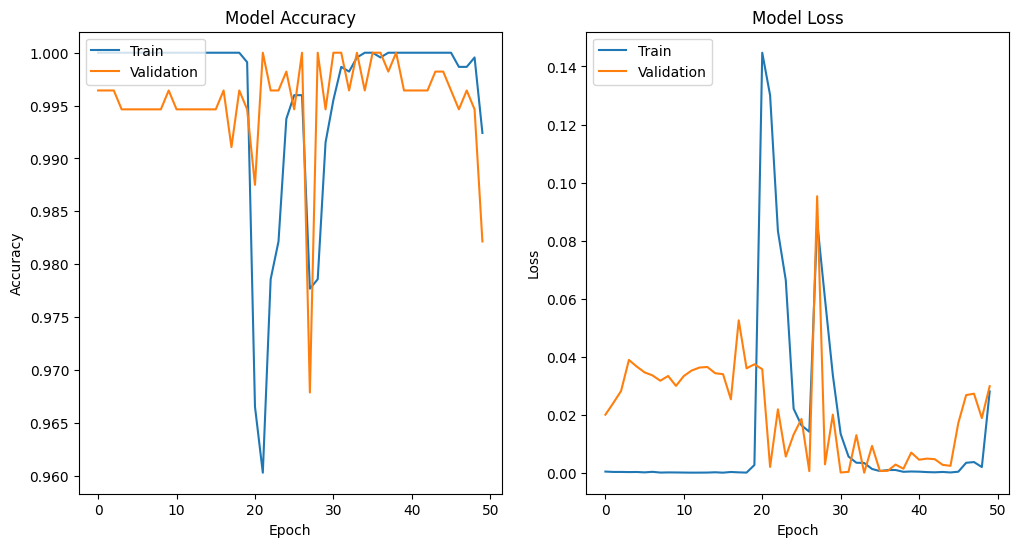

In [ ]:
# Assuming you have 'history' from the model training
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 1s 6ms/step - loss: 0.0069 - accuracy: 0.9982
Test Loss: 0.0068642329424619675
Test Accuracy: 0.9982143044471741
